In [8]:
%matplotlib inline
import mxnet as mx
from mxnet import gluon
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from gluonts.dataset.common import ListDataset
from datetime import datetime, timedelta
from gluonts.model.simple_feedforward import SimpleFeedForwardEstimator
from gluonts.model.deepar import DeepAREstimator
from gluonts.mx.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator
from gluonts.dataset.util import to_pandas
from gluonts.dataset.field_names import FieldName
from gluonts.model.forecast import SampleForecast
from pandas import Timestamp
import itertools
from gluonts.model.estimator import GluonEstimator
from scipy.stats import boxcox
from scipy.special import inv_boxcox

# Data Loading

In [9]:
filename = 'NotFinishedOnTimeContext'

In [10]:
dataset= pd.read_csv(filename +'.csv' )
X= dataset[['name','time', 'countryCode', 'ipAddress', 'level',
 'producer']]
y= dataset.iloc[:,6]
#changing the names of the attributes
gluon_dataset= pd.DataFrame()
gluon_dataset['ds'] = pd.to_datetime(X["time"])
gluon_dataset['y']=y
gluon_dataset['ds'] = gluon_dataset['ds'].dt.tz_convert(None)
gluon_dataset_copy=gluon_dataset.copy()

In [11]:
gluon_dataset_copy

ds          y
0    2021-02-12 12:04:17.490    630.500
1    2021-02-12 12:04:47.490    655.875
2    2021-02-12 12:05:17.490    685.875
3    2021-02-12 12:05:47.490    823.500
4    2021-02-12 12:06:17.490    853.500
...                      ...        ...
2176 2021-02-13 06:12:47.490  61787.000
2177 2021-02-13 06:13:17.490  61817.000
2178 2021-02-13 06:13:47.490  61847.000
2179 2021-02-13 06:14:17.490  61868.000
2180 2021-02-13 06:14:47.490  61868.000

[2181 rows x 2 columns]

In [12]:
for i in range(0,len(gluon_dataset_copy)):
    ds=gluon_dataset_copy['ds'][i]
    gluon_dataset_copy['ds'][i+1]=ds + timedelta(seconds=60)
    ds=gluon_dataset['ds'][i]
    gluon_dataset['ds'][i+1]=ds + timedelta(seconds=60)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


# Data Transformation

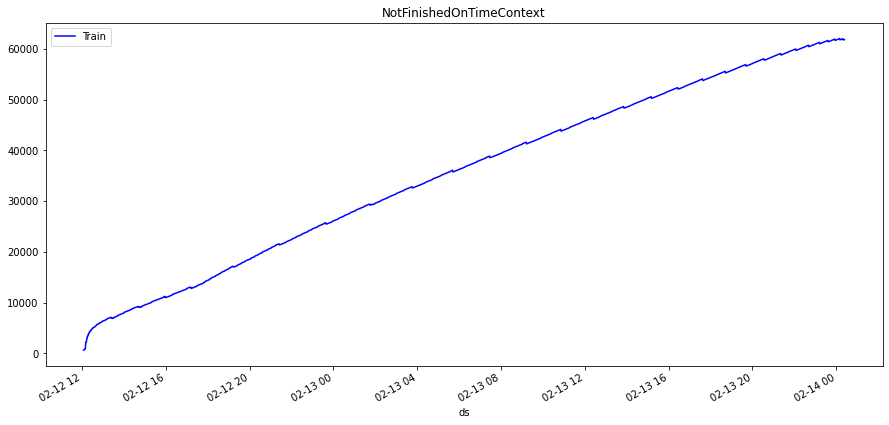

In [13]:
gluon_dataset_copy['y_orig']=gluon_dataset_copy['y']
transformed,lam = boxcox(gluon_dataset_copy['y'])
gluon_dataset_copy['y']=transformed

#plot before transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y_orig', color='blue', label='Train', ax=ax)
plt.title(filename)
plt.show()

#plot after transformation
pd.plotting.register_matplotlib_converters()
f, ax = plt.subplots(figsize=(15,7))
gluon_dataset_copy.plot(kind='line', x='ds', y='y', color='blue', label='Train', ax=ax)
#test.plot(kind='line', x='ds', y='y', color='red', label='Test', ax=ax)
plt.title(filename + "_transformed using Square Root Transformation")
plt.show()

In [14]:
gluon_dataset_copy

ds             y     y_orig
0    2021-02-12 12:04:17.490    324.133081    630.500
1    2021-02-12 12:05:17.490    335.585366    655.875
2    2021-02-12 12:06:17.490    349.055021    685.875
3    2021-02-12 12:07:17.490    409.969535    823.500
4    2021-02-12 12:08:17.490    423.074551    853.500
...                      ...           ...        ...
2176 2021-02-14 00:20:17.490  18132.125680  61787.000
2177 2021-02-14 00:21:17.490  18139.846626  61817.000
2178 2021-02-14 00:22:17.490  18147.567112  61847.000
2179 2021-02-14 00:23:17.490  18152.971177  61868.000
2180 2021-02-14 00:24:17.490  18152.971177  61868.000

[2181 rows x 3 columns]

# Splitting Data into Training and Testing

In [15]:
gluon_dataset_copy=gluon_dataset_copy.set_index('ds')
gluon_dataset=gluon_dataset.set_index('ds')
validation_time =  "2021-02-13 18:00:00"
train_time = "2021-02-13 21:00:00"
test_time = "2021-02-14 00:24:17"
freq='1min'

In [16]:
validation_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:train_time]}],
                         freq=freq
                      )
train_ds = ListDataset([{"start":gluon_dataset_copy.index[0], 
                         "target":gluon_dataset_copy.y[:validation_time]}],
                         freq=freq
                      )
test_ds = ListDataset([{"start":gluon_dataset_copy.index[0],
                        "target":gluon_dataset_copy.y[:test_time]}],
                        freq=freq
                     )
test_orig_ds = ListDataset([{"start":gluon_dataset.index[0],
                        "target":gluon_dataset.y[:test_time]}],
                        freq=freq
                     )

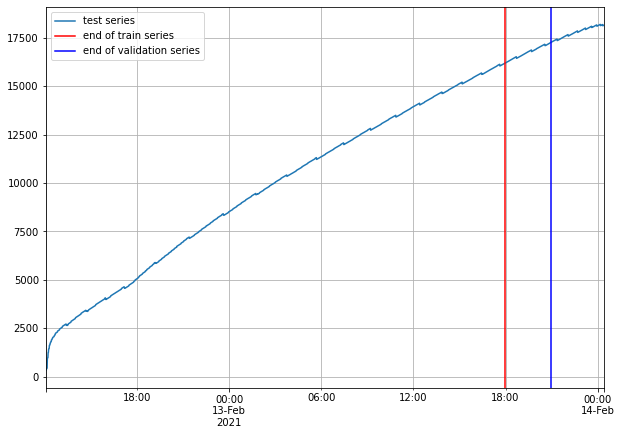

In [17]:
train_entry = next(iter(train_ds))
train_entry.keys()

validation_entry = next(iter(validation_ds))
validation_entry.keys()

test_entry = next(iter(test_ds))
test_entry.keys()

test_orig_entry = next(iter(test_orig_ds))
test_orig_entry.keys()

test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)
validation_series = to_pandas(validation_entry)

prediction_length = len(test_series) - len(validation_series)
context_length = [50,60]


list1=train_series.index
list2=train_entry['target']

d = {'ds':list1,'y':list2}
df_train=pd.DataFrame(d, columns=['ds','y'])

fig, ax = plt.subplots( figsize=(10, 7))

# train_series.plot(ax=ax[0])
# ax[0].grid(which="both")
# ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax)
plt.axvline(train_series.index[-1], color='r') # end of train dataset
plt.axvline(validation_series.index[-1], color='b') # end of validation dataset
ax.grid(which="both")
ax.legend(["test series", "end of train series","end of validation series"], loc="upper left")

plt.show()

In [18]:
prediction_length

205

# Hyper-parameter Tuning

In [19]:
batch_size = [75,100]
epochs = [5,10]
num_batches_per_epoch = [10,20]
learning_rate = [1e-3,1e-4]

In [20]:
from sklearn.model_selection import ParameterGrid

param_grid = {#'num_hidden_dimensions':num_hidden_dimensions,
              'batch_size': batch_size,
              'epochs': epochs,
              'num_batches_per_epoch': num_batches_per_epoch,
              'learning_rate': learning_rate,
              'context_length': context_length
             }
grid = ParameterGrid(param_grid)
cnt = 0
for p in grid:
    cnt = cnt+1

print('Total Possible Models',cnt)

Total Possible Models 32


In [21]:
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
agg_metrics_all=list()
item_metrics_all=list()
for params in all_params:
    estimator = DeepAREstimator(
                        #num_hidden_dimensions=[params['num_hidden_dimensions']],
                        prediction_length=prediction_length,
                        context_length=params['context_length'],
                        freq=freq,
                        trainer=Trainer(ctx="cpu",
                                        epochs=params['epochs'],
                                        learning_rate=params['learning_rate'],
                                        num_batches_per_epoch=params['num_batches_per_epoch']
                                       )
                )
    predictor = estimator.train(training_data = train_ds)
    forecast_it, ts_it = make_evaluation_predictions(
                            dataset=validation_ds,  # test dataset
                            predictor=predictor,  # predictor
                            num_samples=20,  # number of sample paths we want for evaluation
                         )
    forecasts = list(forecast_it)
    #print(forecasts)
    tss = list(ts_it)
    evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
    agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(test_ds))
    #agg_metrics['num_hidden_dimensions'] = params['num_hidden_dimensions']
    agg_metrics['epochs'] = params['epochs']
    agg_metrics['learning_rate'] = params['learning_rate']
    agg_metrics['num_batches_per_epoch'] = params['num_batches_per_epoch']
    agg_metrics['context_length'] = params['context_length']
    agg_metrics['forecast'] = forecasts
    agg_metrics_all.append(agg_metrics)
    item_metrics_all.append(item_metrics)
    
dataframe = pd.DataFrame(agg_metrics_all)
print(dataframe)


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/10 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


Running evaluation: 100%|██████████| 1/1 [00:20<00:00, 20.02s/it]


             MSE      abs_error  abs_target_sum  abs_target_mean  \
0   1.689306e+05   73417.250000       3420584.5     16685.778049   
1   2.147892e+05   73848.210938       3420584.5     16685.778049   
2   1.540538e+07  521079.218750       3420584.5     16685.778049   
3   9.342630e+06  549428.125000       3420584.5     16685.778049   
4   1.967400e+06  286325.250000       3420584.5     16685.778049   
5   3.078848e+06  337776.031250       3420584.5     16685.778049   
6   3.317801e+06  283429.000000       3420584.5     16685.778049   
7   3.819017e+06  332406.000000       3420584.5     16685.778049   
8   6.277202e+04   35204.429688       3420584.5     16685.778049   
9   4.101787e+05  116527.351562       3420584.5     16685.778049   
10  3.087396e+06  327345.750000       3420584.5     16685.778049   
11  4.749008e+06  392740.937500       3420584.5     16685.778049   
12  2.581819e+05   93576.046875       3420584.5     16685.778049   
13  1.584189e+05   65447.281250       3420584.5 

In [22]:
sorted1 = dataframe.sort_values(by=['MAPE'])
sorted1 = sorted1.reset_index(drop=True)

In [23]:
sorted1

MSE      abs_error  abs_target_sum  abs_target_mean  \
0   8.154037e+03   13711.722656       3420584.5     16685.778049   
1   1.232782e+04   20375.207031       3420584.5     16685.778049   
2   1.725156e+04   25416.460938       3420584.5     16685.778049   
3   5.088612e+04   34909.781250       3420584.5     16685.778049   
4   6.277202e+04   35204.429688       3420584.5     16685.778049   
5   7.011780e+04   50524.328125       3420584.5     16685.778049   
6   1.584189e+05   65447.281250       3420584.5     16685.778049   
7   1.787495e+05   72204.835938       3420584.5     16685.778049   
8   1.689306e+05   73417.250000       3420584.5     16685.778049   
9   2.147892e+05   73848.210938       3420584.5     16685.778049   
10  2.160047e+05   78910.828125       3420584.5     16685.778049   
11  3.253212e+05   78673.375000       3420584.5     16685.778049   
12  2.877412e+05   89096.187500       3420584.5     16685.778049   
13  2.581819e+05   93576.046875       3420584.5     16685.778049   
14  4.101787e+05  116527.351562       3420584.5     16685.778049   
15  4.123234e+05  118537.960938       3420584.5     16685.778049   
16  1.204194e+06  208455.843750       3420584.5     16685.778049   
17  1.631567e+06  232361.000000       3420584.5     16685.778049   
18  1.504699e+06  248633.578125       3420584.5     16685.778049   
19  3.317801e+06  283429.000000       3420584.5     16685.778049   
20  1.967400e+06  286325.250000       3420584.5     16685.778049   
21  2.896758e+06  315753.812500       3420584.5     16685.778049   
22  3.087396e+06  327345.750000       3420584.5     16685.778049   
23  3.819017e+06  332406.000000       3420584.5     16685.778049   
24  3.078848e+06  337776.031250       3420584.5     16685.778049   
25  4.749008e+06  392740.937500       3420584.5     16685.778049   
26  4.371696e+06  426842.312500       3420584.5     16685.778049   
27  1.540538e+07  521079.218750       3420584.5     16685.778049   
28  8.095468e+06  520374.281250       3420584.5     16685.778049   
29  9.342630e+06  549428.125000       3420584.5     16685.778049   
30  3.137292e+07  573562.375000       3420584.5     16685.778049   
31  5.852112e+07  839359.125000       3420584.5     16685.778049   

    seasonal_error        MASE      MAPE     sMAPE  OWA          MSIS  ...  \
0        10.527579    6.353451  0.004018  0.004016  NaN     92.461732  ...   
1        10.527579    9.441036  0.005986  0.005963  NaN    130.220194  ...   
2        10.527579   11.776947  0.007443  0.007408  NaN    121.711706  ...   
3        10.527579   16.175763  0.010127  0.010190  NaN    185.315524  ...   
4        10.527579   16.312291  0.010201  0.010272  NaN    240.445896  ...   
5        10.527579   23.410904  0.014759  0.014620  NaN    310.723966  ...   
6        10.527579   30.325589  0.018901  0.019153  NaN    254.637859  ...   
7        10.527579   33.456763  0.020866  0.021166  NaN    229.365504  ...   
8        10.527579   34.018546  0.021313  0.021012  NaN    285.527805  ...   
9        10.527579   34.218236  0.021533  0.021249  NaN    411.600443  ...   
10       10.527579   36.564045  0.022890  0.023251  NaN    222.870890  ...   
11       10.527579   36.454019  0.023010  0.022927  NaN    937.659721  ...   
12       10.527579   41.283524  0.026103  0.025661  NaN    569.582128  ...   
13       10.527579   43.359307  0.027146  0.027575  NaN    526.585653  ...   
14       10.527579   53.994002  0.033784  0.034477  NaN    403.791280  ...   
15       10.527579   54.925636  0.034361  0.035070  NaN    821.317448  ...   
16       10.527579   96.589899  0.060558  0.062658  NaN   1064.086308  ...   
17       10.527579  107.666569  0.067481  0.070184  NaN    706.372030  ...   
18       10.527579  115.206616  0.072382  0.069654  NaN    650.096090  ...   
19       10.527579  131.329389  0.082726  0.078228  NaN   2602.486156  ...   
20       10.527579  132.671392  0.083370  0.079889  NaN   2167.742550  ...   
21       10.527579  146.307383  0.092484  0.087316  

# Forecast and Evaluation

In [24]:
estimator = DeepAREstimator(
    #num_hidden_dimensions=[sorted1['num_hidden_dimensions'][0]],
    prediction_length=prediction_length,
    context_length=sorted1['context_length'][0],
    freq=freq,
    trainer=Trainer(ctx="cpu",
                    epochs=sorted1['epochs'][0],
                    learning_rate=learning_rate[0],
                    num_batches_per_epoch=sorted1['num_batches_per_epoch'][0]
                   )
)

In [25]:
predictor = estimator.train(train_ds)

  0%|          | 0/20 [00:00<?, ?it/s]

learning rate from ``lr_scheduler`` has been overwritten by ``learning_rate`` in optimizer.


100%|██████████| 20/20 [00:08<00:00,  2.34it/s, epoch=10/10, avg_epoch_loss=6.33]


# Save the Model 

In [36]:
from pathlib import Path
predictor.serialize(Path("Models/BoxCox"))

# loads it back
# from gluonts.model.predictor import Predictor
# predictor_deserialized = Predictor.deserialize(Path("Models/CubeRoot"))
# print(predictor_deserialized)

In [37]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=100,  # number of sample paths we want for evaluation
)

forecasts = list(forecast_it)
tss = list(ts_it)
ts_entry = tss[0]
forecast_entry = forecasts[0]

forecasts_val=sorted1['forecast'][0]
forecast_entry_val = forecasts_val[0]



In [38]:
#return forecast to original
#inv = np.vectorize(log_inverse_transformation)

forecast_entry.samples = inv_boxcox(forecast_entry.samples,lam)
forecast_entry_inv=SampleForecast(freq=freq, start_date=forecast_entry.start_date, samples=forecast_entry.samples)

forecast_entry_val.samples = inv_boxcox(forecast_entry_val.samples,lam)
forecast_entry_val_inv=SampleForecast(freq=freq, start_date=forecast_entry_val.start_date, samples=forecast_entry_val.samples)

ts_entry_inv=inv_boxcox(ts_entry,lam)
ts_entry_inv_df=pd.DataFrame(ts_entry_inv, index=ts_entry.index)
tss_inv=list()
tss_inv.append(ts_entry_inv_df)

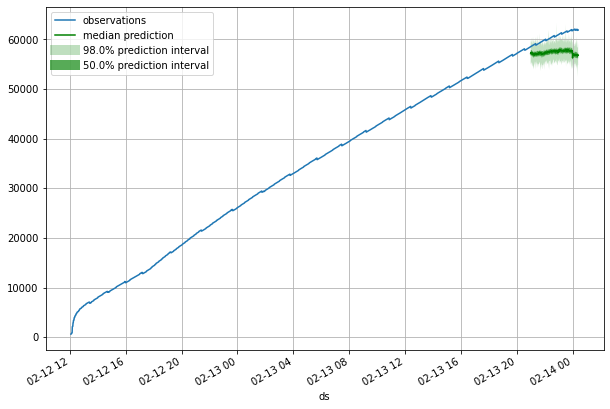

In [39]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = len(ts_entry)
    prediction_intervals = (50.0,98.0)
    legend = ["observations", "median prediction"] + [f"{k}% prediction interval" for k in prediction_intervals][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(10, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color='g')
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()
plot_prob_forecasts(gluon_dataset['y'], forecast_entry_inv)

In [40]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])
agg_metrics, item_metrics = evaluator(iter(tss_inv), iter([forecast_entry_inv]), num_series=len(test_ds))


Running evaluation: 100%|██████████| 1/1 [00:02<00:00,  2.32s/it]


In [41]:
agg_metrics

{'MSE': 10965118.126829268,
 'abs_error': 644486.4375,
 'abs_target_sum': 12403754.0,
 'abs_target_mean': 60506.11707317073,
 'seasonal_error': 35.61951740506329,
 'MASE': 88.2616191773814,
 'MAPE': 0.05169411506950936,
 'sMAPE': 0.05320198627579029,
 'OWA': nan,
 'MSIS': 1546.6661665436593,
 'QuantileLoss[0.1]': 172857.075,
 'Coverage[0.1]': 0.0,
 'QuantileLoss[0.5]': 644486.4453125,
 'Coverage[0.5]': 0.0,
 'QuantileLoss[0.9]': 772618.3171874998,
 'Coverage[0.9]': 0.0,
 'RMSE': 3311.361974600371,
 'NRMSE': 0.054727722332535464,
 'ND': 0.05195898253867337,
 'wQuantileLoss[0.1]': 0.013935867721981588,
 'wQuantileLoss[0.5]': 0.051958983168523015,
 'wQuantileLoss[0.9]': 0.06228907129144127,
 'mean_absolute_QuantileLoss': 529987.2791666667,
 'mean_wQuantileLoss': 0.04272797406064863,
 'MAE_Coverage': 0.5}

# Residual

In [42]:
#get the mean for all the samples
f1 = forecast_entry_val_inv.samples.mean(axis=0)
f2 = forecast_entry_inv.samples.mean(axis=0)

In [43]:
original_values=list(gluon_dataset['y'])
orig_test = original_values[:len(original_values)-prediction_length]
test_extract=original_values[-prediction_length:]
val_extract=orig_test[-prediction_length:]

In [44]:
valandtest_orig=list()
valandtest_pred=list()
for a1 in val_extract:
    valandtest_orig.append(a1)

for b1 in test_extract:
    valandtest_orig.append(b1)
    
for a2 in f1:
    valandtest_pred.append(a2)

for b2 in f2:
    valandtest_pred.append(b2)


In [45]:
residuals = abs(np.array(valandtest_pred)-np.array(valandtest_orig))
residuals_df=pd.DataFrame()
residuals_df['residuals']=residuals
#residuals_df['ds']=prophet_dataset2['ds']

f, ax = plt.subplots(figsize=(15,7))
ax.text(x=len(val_extract)/2 -10,y=30000, s='Validation Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.text(x=len(val_extract)+10,y=30000, s='Testing Data', color='black', fontsize=15, fontweight='bold', alpha=0.8)
ax.axvline(x=len(val_extract), c='green', lw=3, alpha=0.8, ls='--')
residuals_df.plot(kind='line',  y='residuals', color='blue', label='Residual',figsize=(15, 6),ax=ax)
plt.title("Residuals")

Text(0.5, 1.0, 'Residuals')

# Saving the Predictions

In [46]:
predictions_df=pd.DataFrame()
predictions_df['original'] = valandtest_orig
predictions_df['predictions'] = valandtest_pred
predictions_df.to_csv(Path("Predictions/BoxCox.csv"),index=False)